In [1]:
import numpy as np
from numpy import array, arange, zeros, ones, concatenate, linspace
import pickle

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rc('text', usetex=True)

In [2]:
n = 7
m_list = arange(2, 2*n + 1, 2)
k = 2

s_min = 0
s_max = 49
r_min = 0
r_max = 49
p_min = 1
p_max = 150

In [3]:
path = "/home/kardashin/Work/QAOA-QFI/Data/"
post = "-prevsol" 
file_name = path + "sat-" + f"n={n}-k={k}-m=({m_list[0]},{m_list[-1]})-p=({p_min},{p_max})-s=({s_min},{s_max})-r=({r_min},{r_max})" + post 

In [4]:
with open(file_name + ".dict", 'rb') as fp:
    data_dict = pickle.load(fp)
data_dict.keys()

dict_keys(['n', 'm_list', 's_min', 's_max', 'r_min', 'r_max', 'p_min', 'p_max', 'funs_list', 'errors_list', 'nits_list', 'nfevs_list', 'times_list', 'EQD_list', 'H_diag_list', 'note'])

In [5]:
errors_list = data_dict["errors_list"]
EQD_list = data_dict["EQD_list"]
p_c_list = np.floor(np.max(EQD_list, axis=2)/2)

In [11]:
### count converged ###

discard_nonconv = False
cumulative = True
error_threshold = 1e-8

p_star_list = [] # [m][s]
counts_list = []
bad_indeces_list = []
for m_i in range(len(m_list)):
    counts_prob = []
    p_star_prob = []
    bad_indeces_prob = []
    for s in range(s_min, s_max + 1):
        conv_flag = False
        counts_s = zeros(p_max - p_min + 1)
        p_star_s = 2**n - 1
        for r in range(r_min, r_max + 1):
            counts_r = zeros(p_max - p_min + 1)
            for p_i in range(p_max - p_min):
                if errors_list[m_i][s][r][p_i] < error_threshold:
                    conv_flag = True
                    if p_i + 1 < p_star_s: # redundant?
                        p_star_s = p_i + 1 # p_i is an index: +1 for counting from zero
                    if cumulative == True:
                        counts_r += concatenate([zeros(p_i + 1), ones(p_max - p_min - p_i)])
                        break
                    else:
                        counts_r[p_i + 1] += 1
            counts_s += counts_r
        if conv_flag == False:
            print(f"No convergence for (thr={error_threshold}, prob={m_list[m_i]}, s={s})")
            if discard_nonconv == True:
                p_star_s = np.nan # can be counted easily, if needed
            bad_indeces_prob.append( s )
        counts_prob.append(counts_s)
        p_star_prob.append(p_star_s)
    p_star_list.append(p_star_prob)
    counts_list.append(counts_prob)
    bad_indeces_list.append(bad_indeces_prob)

No convergence for (thr=1e-08, prob=8, s=10)
No convergence for (thr=1e-08, prob=10, s=48)
No convergence for (thr=1e-08, prob=12, s=7)


In [12]:
errors_min_list = np.min(errors_list, axis=2)
errors_min_cum_list = []
for m_i in range(len(m_list)):
    errors_min_cum_prob = []
    for s in range(s_min, s_max + 1):
        errors_min_cum_s = [errors_min_list[m_i][s][0]]
        for p in range(1, p_max - p_min + 1):
            if errors_min_list[m_i][s][p] < errors_min_cum_s[-1]:
                errors_min_cum_s.append(errors_min_list[m_i][s][p])
            else:
                errors_min_cum_s.append(errors_min_cum_s[-1])
        errors_min_cum_prob.append(errors_min_cum_s)
    errors_min_cum_list.append(errors_min_cum_prob)

In [13]:
print(f"Converged with (p^* > p_c) to {error_threshold}:")
for m_i in range(len(m_list)):
    for s in range(s_min, s_max + 1):
        if p_star_list[m_i][s] > p_c_list[m_i][s]:
            print(f"\tprob: {prob_list[m_i]} | s: {s} | p_c: {int(p_c_list[m_i][s])} | p^*: {p_star_list[m_i][s]}")

print(f"\nNot converged to {error_threshold}:", sum([np.count_nonzero(line) for line in bad_indeces_list]))

Converged with (p^* > p_c) to 1e-08:

Not converged to 1e-08: 3


# Plots from the paper

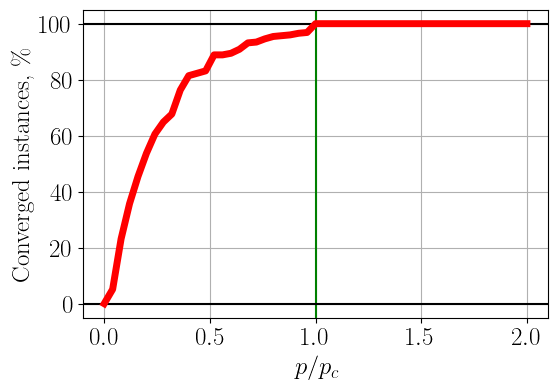

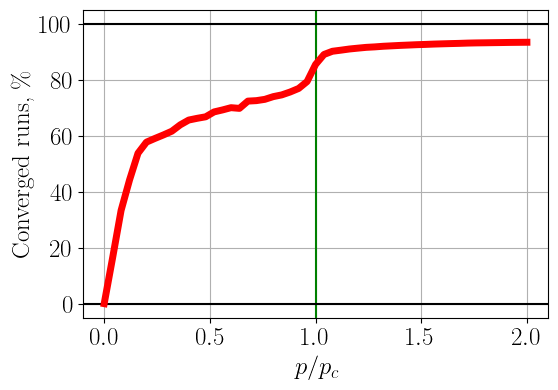

In [14]:
n_bins = 50
p_c_star_bins = linspace(0, 2, n_bins + 1)

p_sc = np.sort((p_star_list/p_c_list).reshape(350))
p_c_star_counts_s = []
for bi in p_c_star_bins:
    p_c_star_counts_s.append(len(np.where(p_sc <= bi)[0]))
p_c_star_counts_s = array(p_c_star_counts_s)/(len(m_list)*(s_max - s_min + 1)/100)

p_sc = p_star_list/p_c_list
p_c_star_counts_r = []
for bi in p_c_star_bins:
    arr_c = array(counts_list)[np.where(p_sc <= bi)]
    arr_i = array(np.floor(bi*p_c_list[np.where(p_sc <= bi)]), dtype=int)
    li_sum = sum([arr_c[i][arr_i[i]] if arr_i[i] < (p_max - p_min + 1) else arr_c[i][p_max - 1] for i in range(len(arr_c))])
    li_sum = li_sum/((r_max - r_min + 1)*len(arr_c))*100 if len(arr_c) > 0 else 0
    p_c_star_counts_r.append(li_sum)
p_c_star_counts_r = array(p_c_star_counts_r)

matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(6, 4))
plt.axvline(1, color="green")
plt.axhline(0, color="black")
plt.axhline(100, color="black")
plt.plot(p_c_star_bins, p_c_star_counts_s, linewidth=5, color="red")
plt.xlabel("$p/p_c$")
plt.ylabel("Converged instances, \%")
plt.grid()

matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(6, 4))
plt.axvline(1, color="green")
plt.axhline(0, color="black")
plt.axhline(100, color="black")
plt.plot(p_c_star_bins, p_c_star_counts_r, linewidth=5, color="red")
plt.xlabel("$p/p_c$")
plt.ylabel("Converged runs, \%")
plt.grid()

In [10]:
np.save("/home/kardashin/Work/QAOA-QFI/Results/" + f"sat-bins-counts_s_r.npy", array([p_c_star_bins, p_c_star_counts_s, p_c_star_counts_r]))

# Other plots

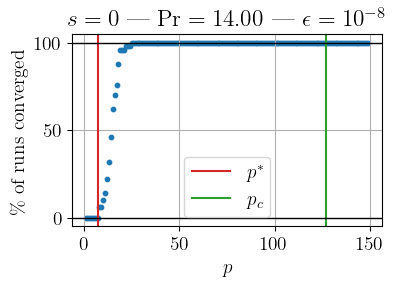

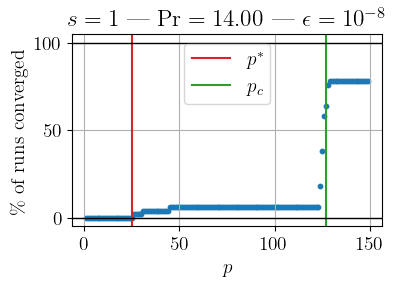

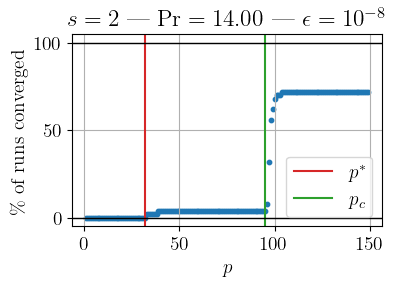

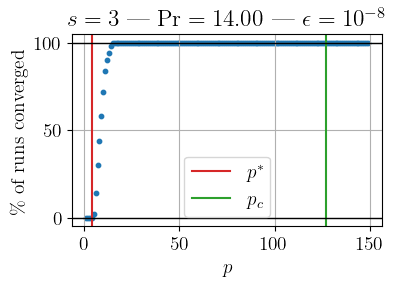

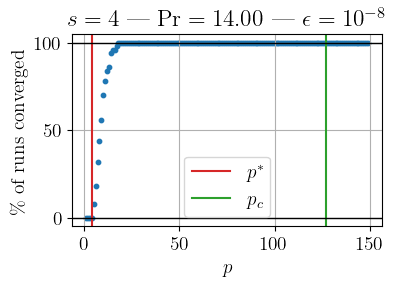

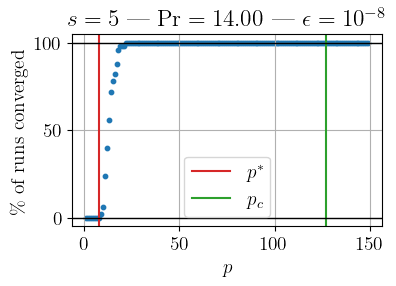

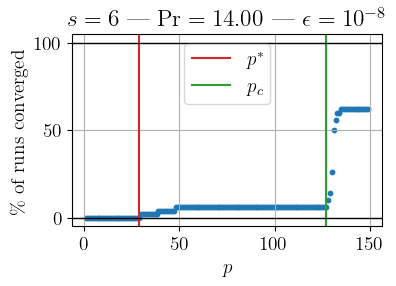

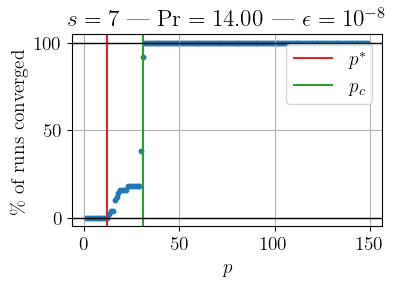

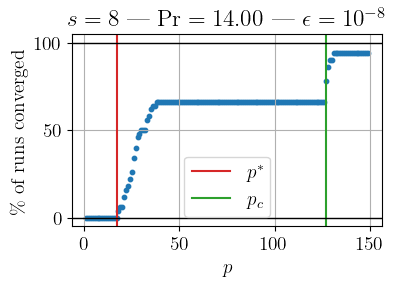

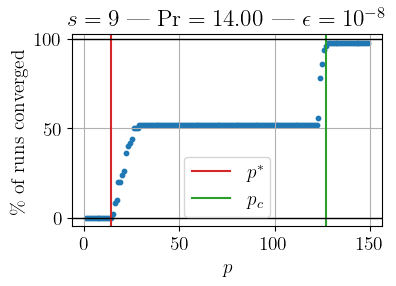

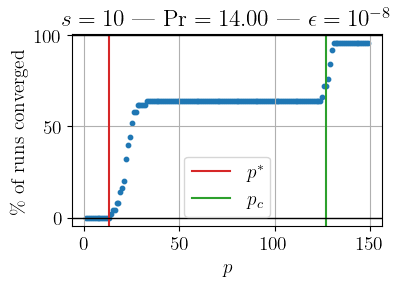

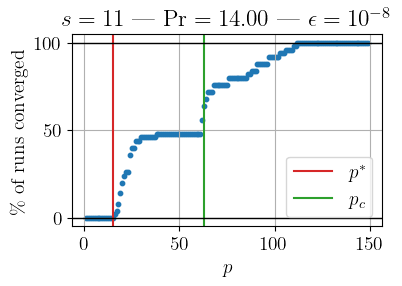

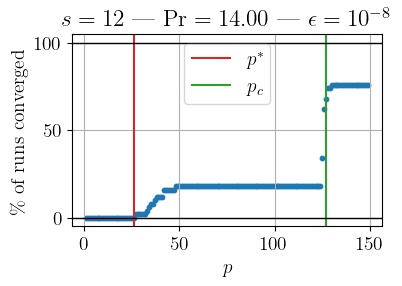

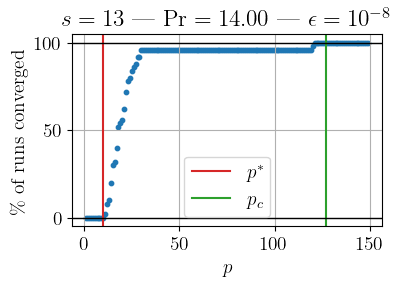

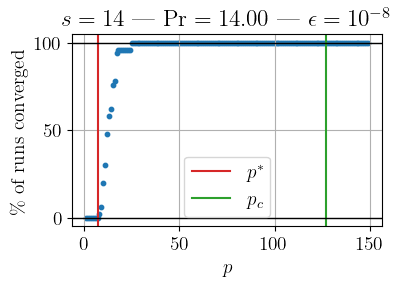

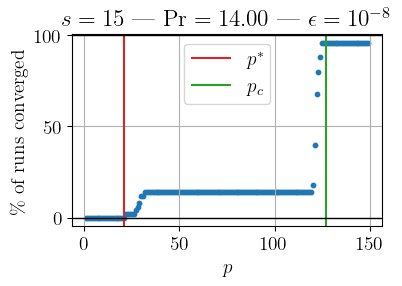

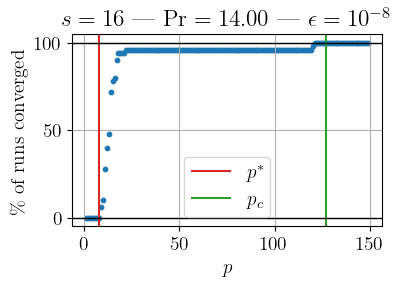

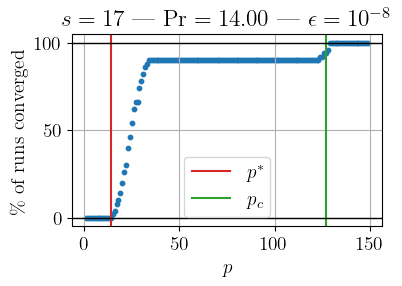

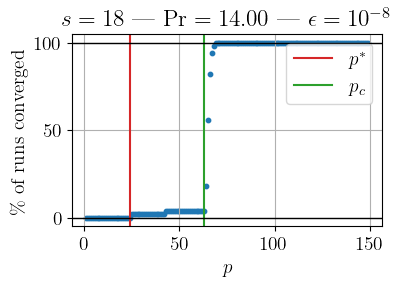

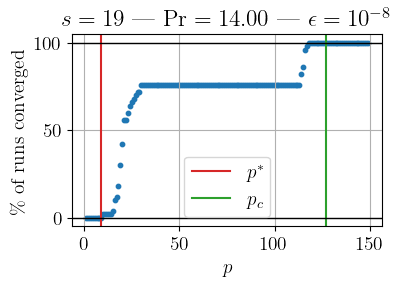

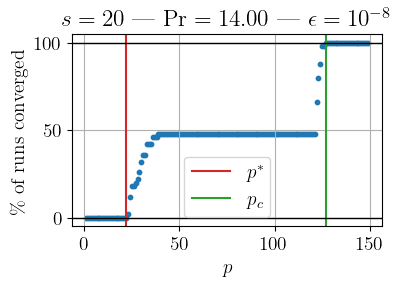

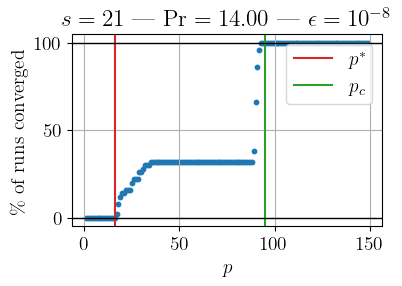

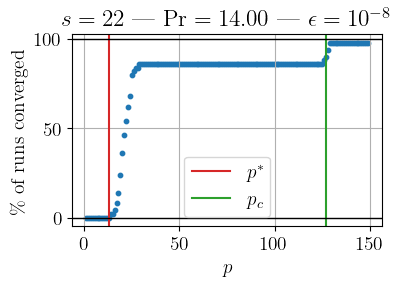

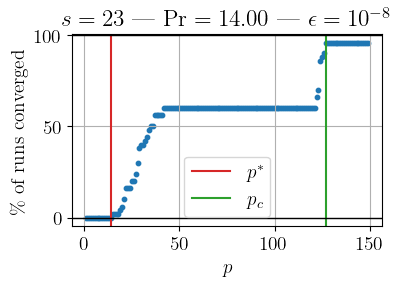

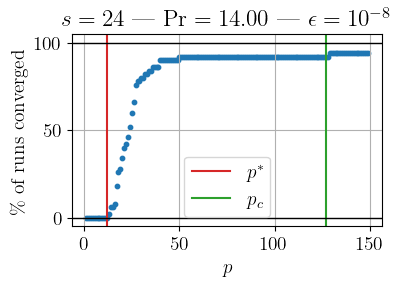

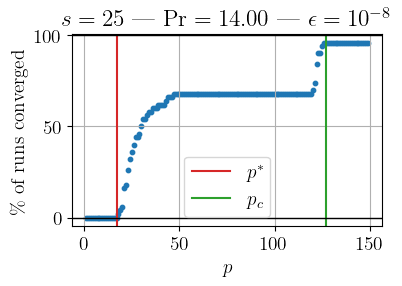

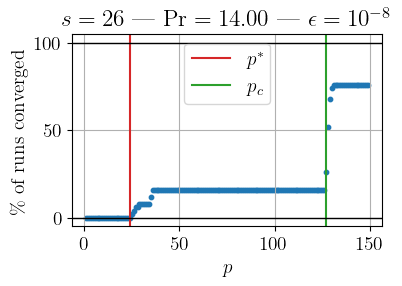

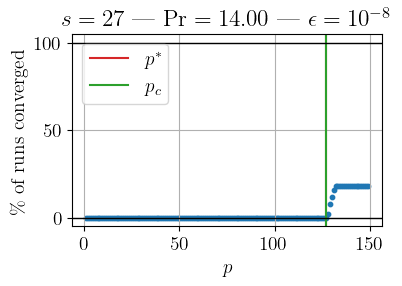

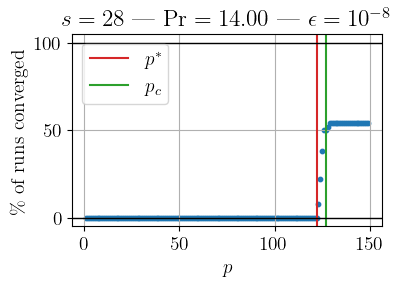

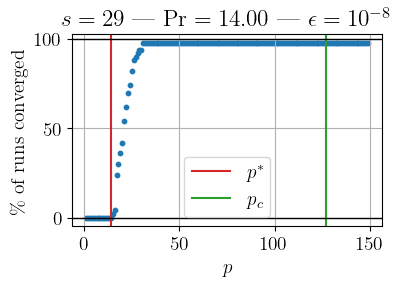

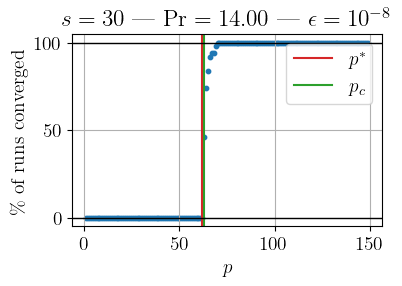

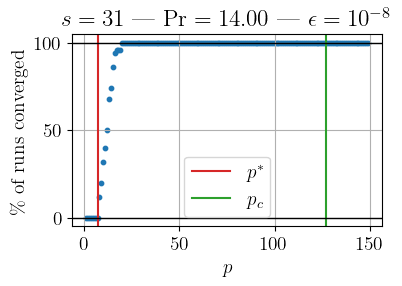

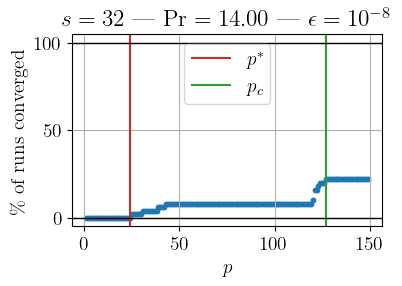

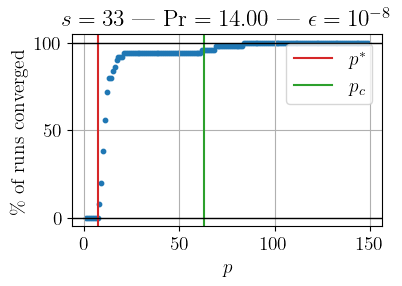

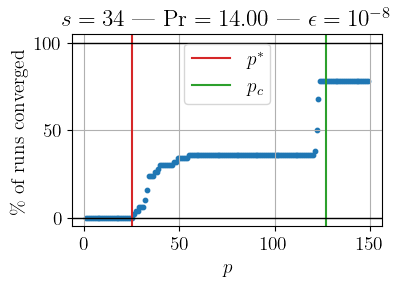

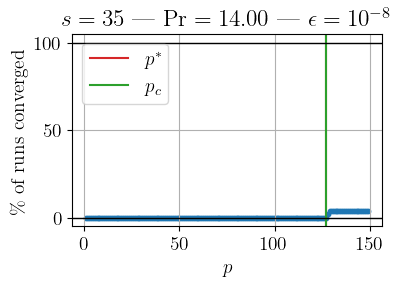

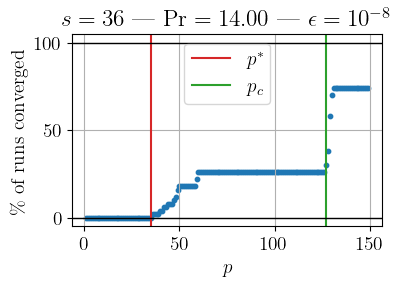

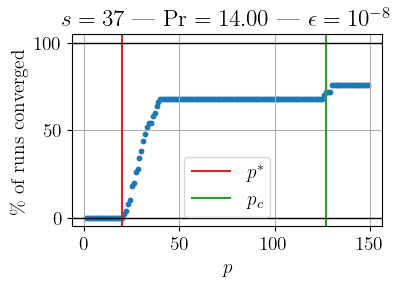

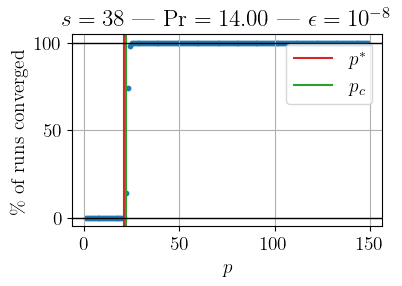

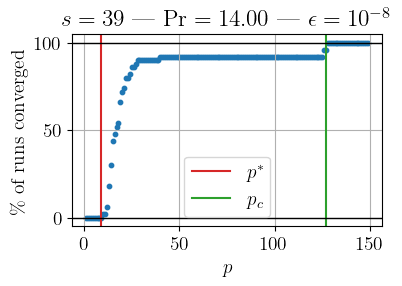

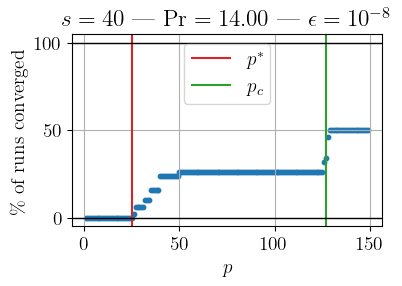

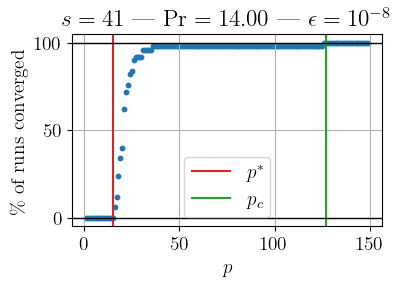

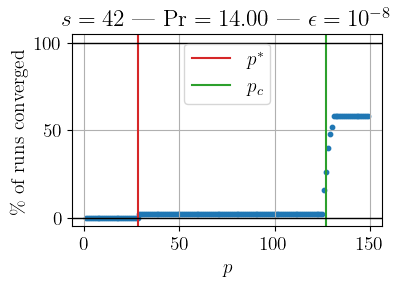

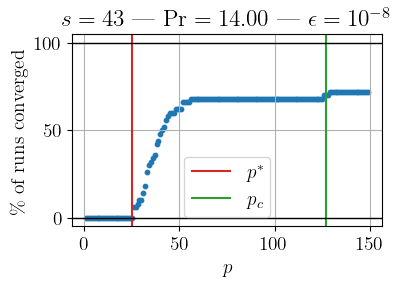

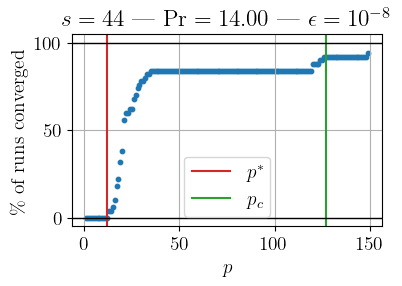

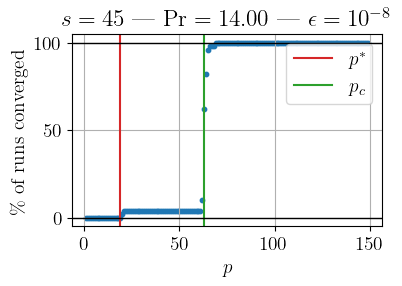

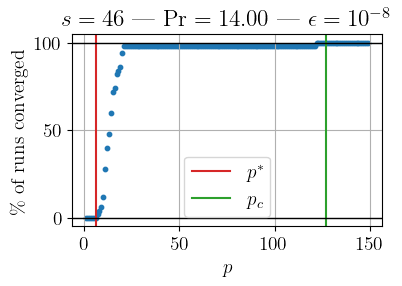

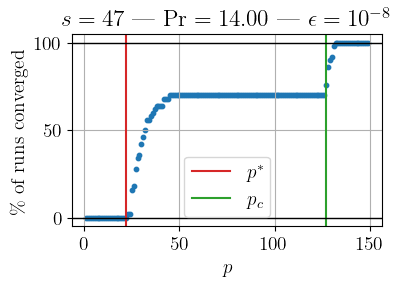

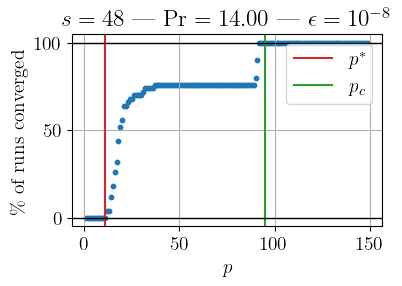

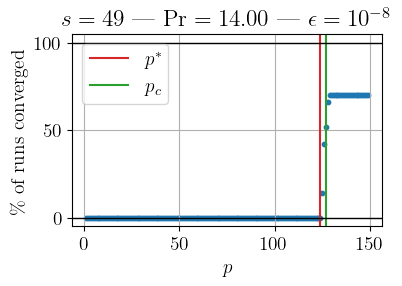

In [40]:
m_i = -1

sta = 0
fin = -1

matplotlib.rcParams.update({'font.size': 14})
# print("Not converged:", len(bad_indeces))
for s in range(s_max - s_min + 1):
    plt.figure(figsize=(4, 2.5))
    plt.scatter(arange(p_min, p_max + 1)[sta:fin], counts_list[m_i][s][sta:fin]/(r_max - r_min + 1)*100, s=10)
    plt.axvline(p_star_list[m_i][s], color="tab:red", label=r"$p^*$")
    plt.axvline(p_c_list[m_i][s], color="tab:green", label=r"$p_c$")
    plt.axhline(0, color="black", linewidth=1)
    # plt.axhline(r_max + 1, color="black", linewidth=1)
    plt.axhline(100, color="black", linewidth=1)
    plt.xlabel(r"$p$")
    plt.ylabel(r"\% of runs converged")
    plt.title(r"$s=%d$ | $\mathrm{Pr}=%.2f$ | $\epsilon=10^{%d}$" %(s, m_list[m_i], int(np.log10(error_threshold))))
    # plt.ylim(-1, r_max + 1)
    plt.grid()
    plt.legend()
    # plt.savefig(file_name + ".png", transparent=True, bbox_inches='tight')
    plt.show()

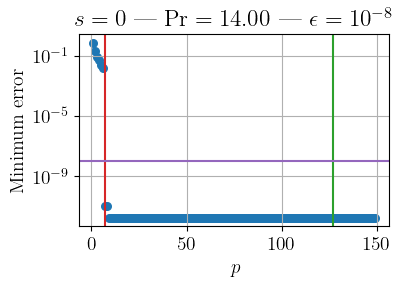

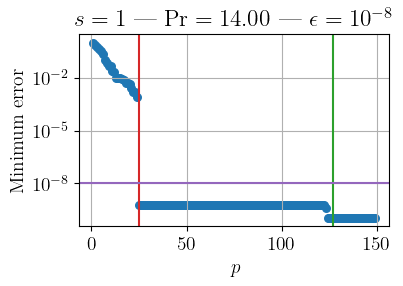

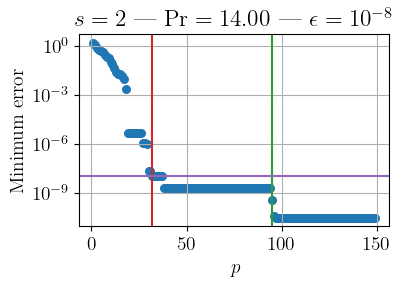

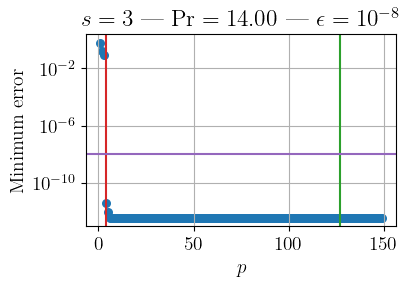

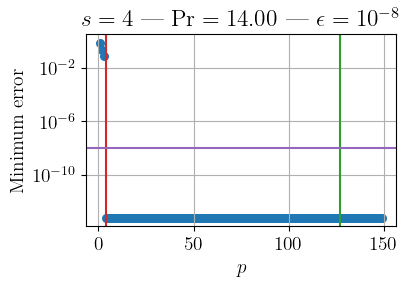

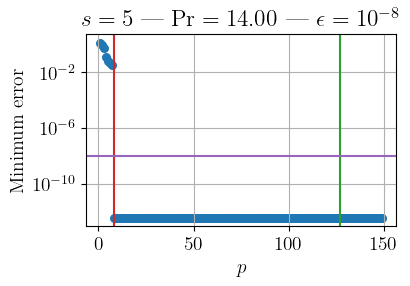

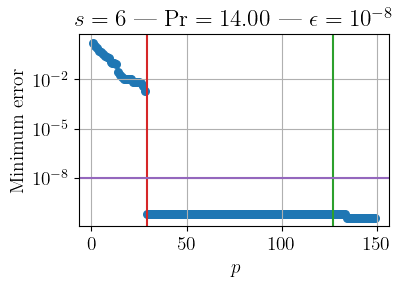

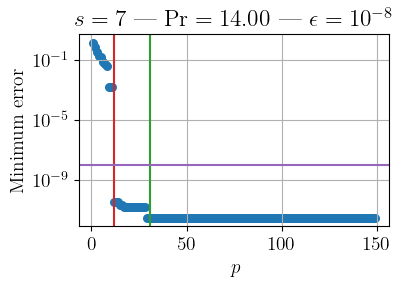

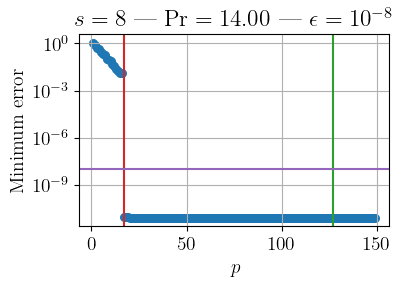

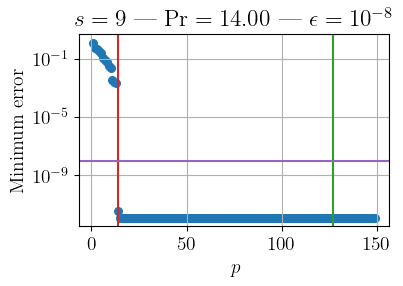

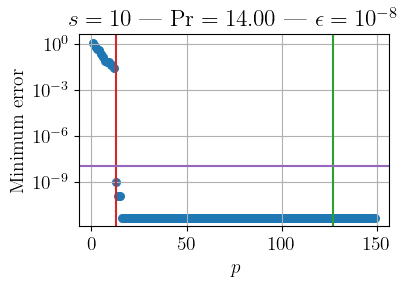

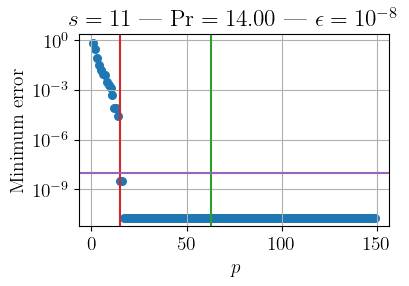

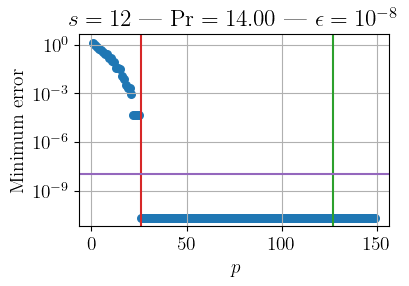

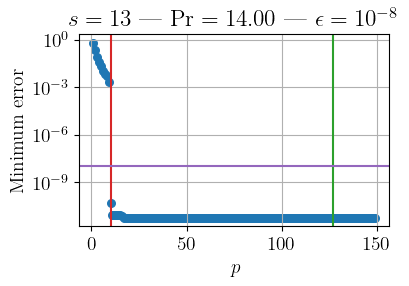

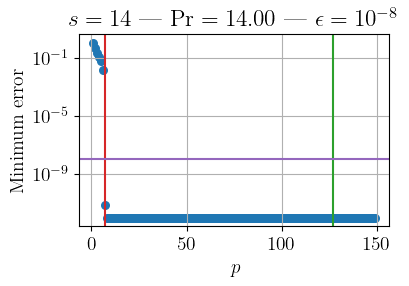

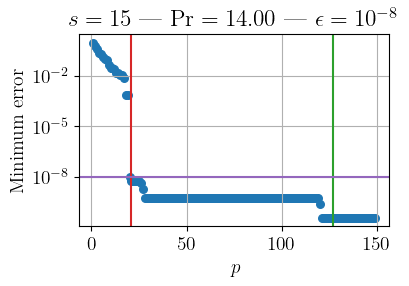

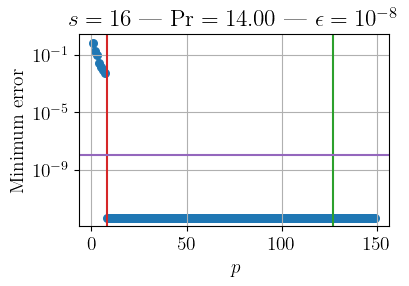

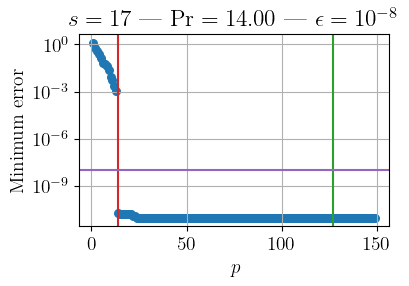

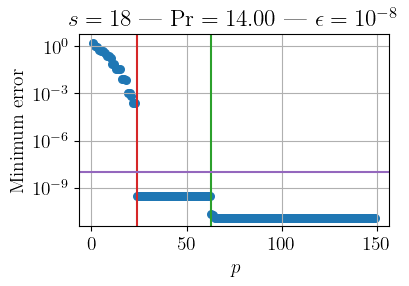

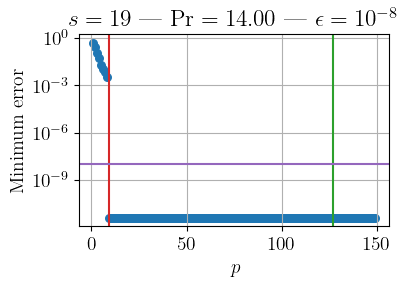

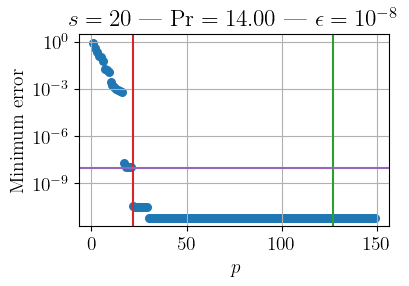

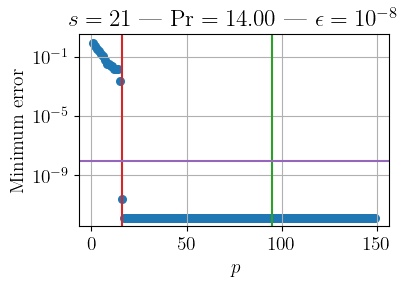

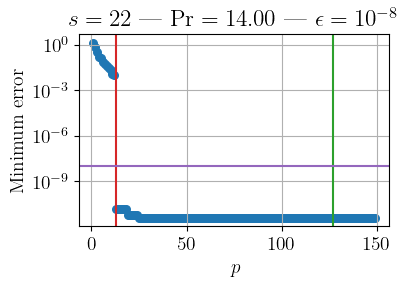

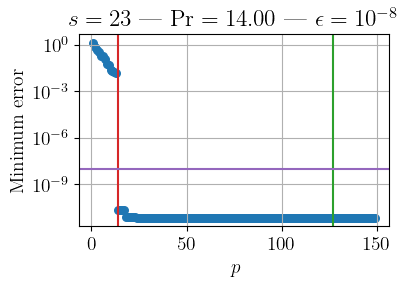

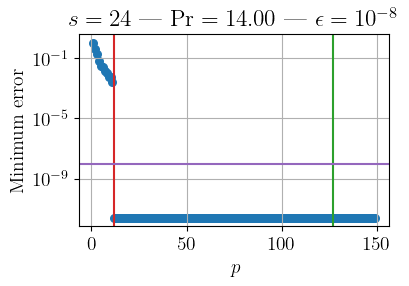

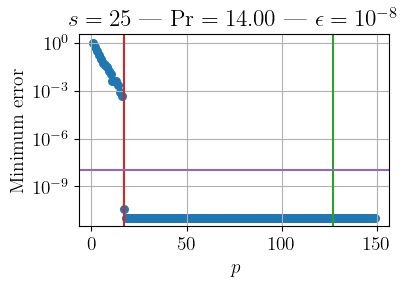

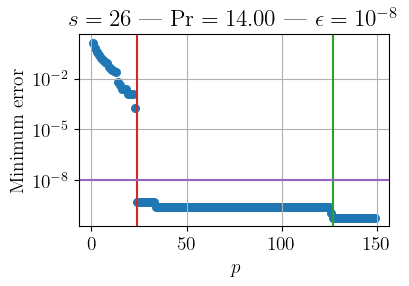

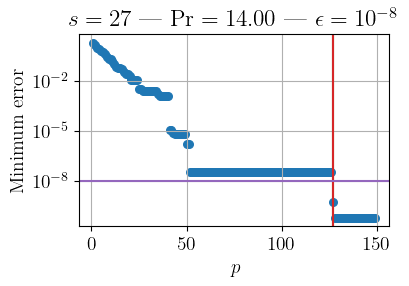

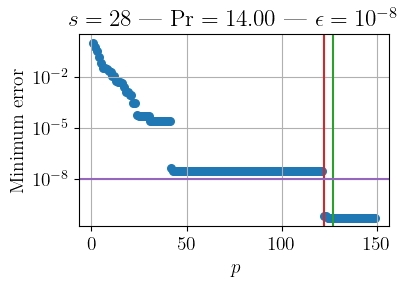

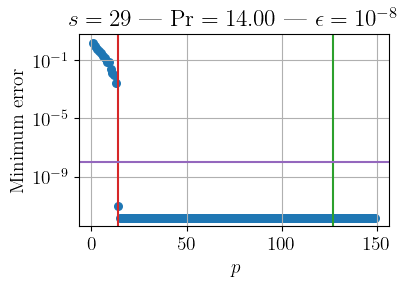

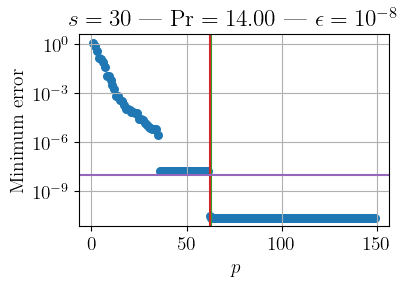

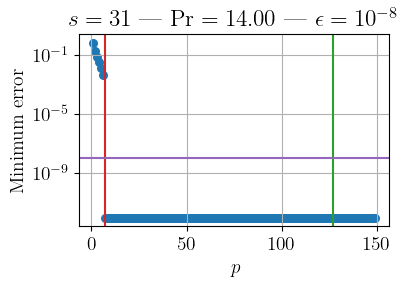

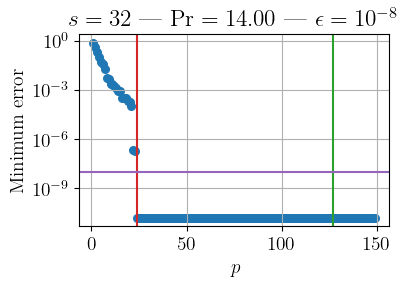

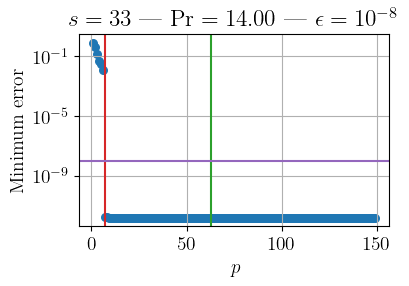

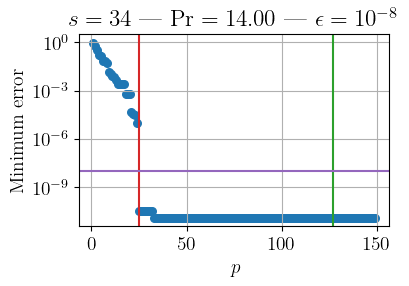

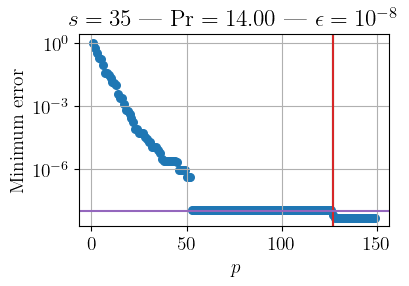

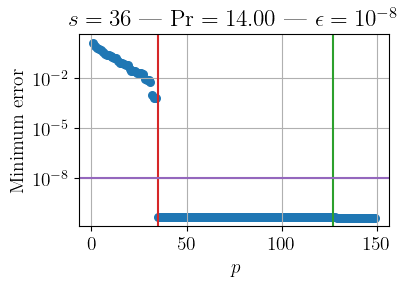

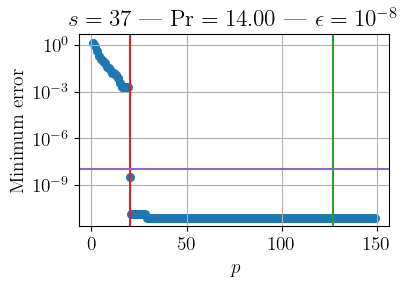

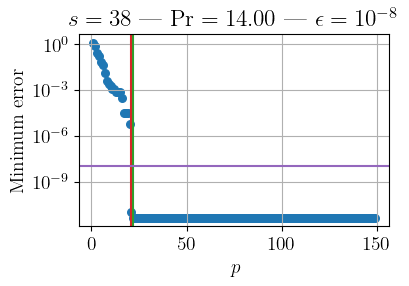

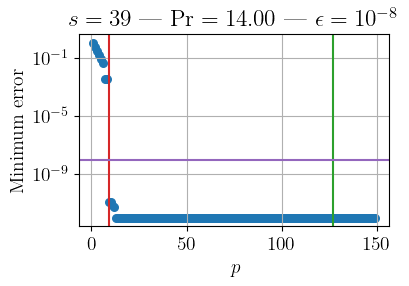

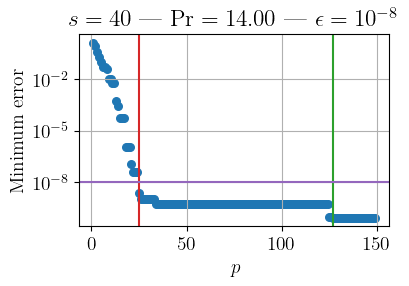

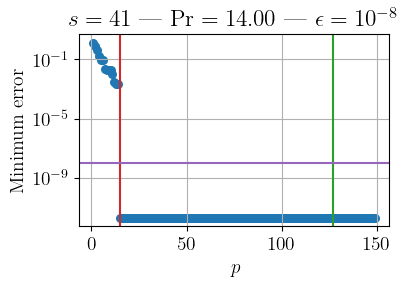

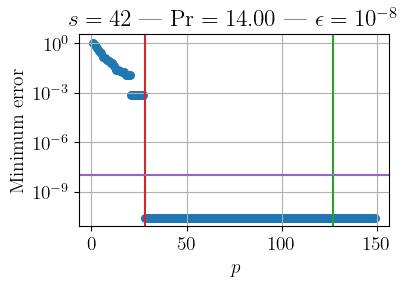

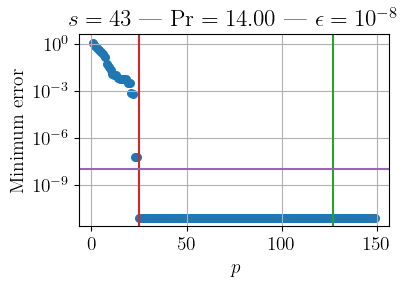

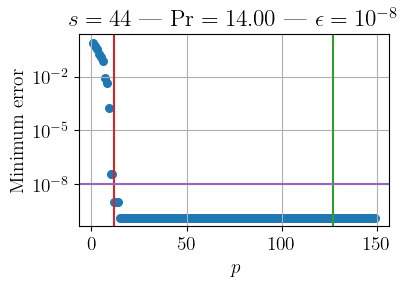

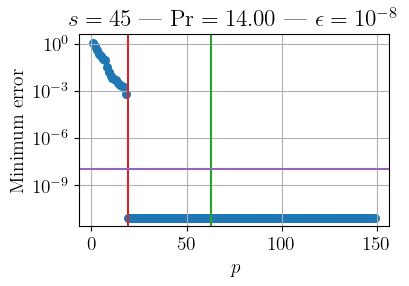

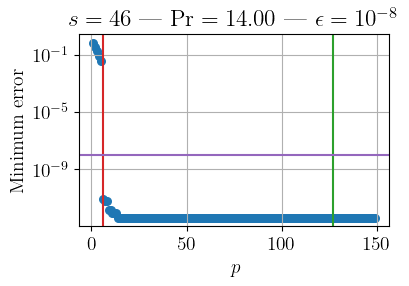

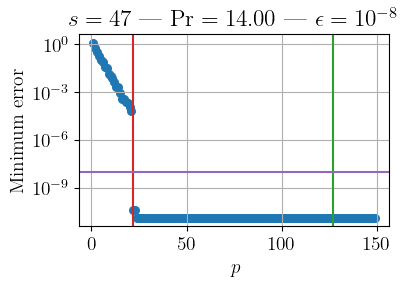

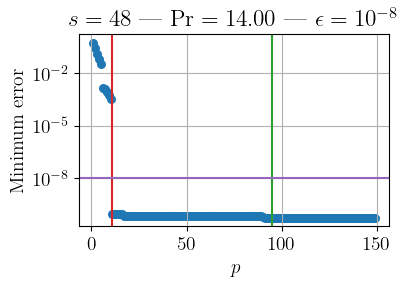

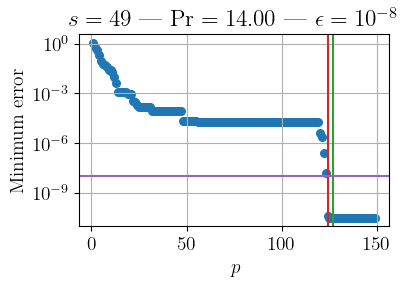

In [42]:
m_i = -1

sta = 0
fin = -1

matplotlib.rcParams.update({'font.size': 14})
for s in range(s_max - s_min + 1):
    plt.figure(figsize=(4, 2.5))
    plt.scatter(arange(p_min, p_max + 1)[sta:fin], errors_min_cum_list[m_i][s][sta:fin], s=30)
    # plt.scatter(arange(p_min, p_max + 1)[sta:fin], errors_min_list[m_i][s][sta:fin], s=30)
    plt.axvline(p_c_list[m_i][s], color="tab:green", label=r"$p_c$")
    plt.axvline(p_star_list[m_i][s], color="tab:red", label=r"$p^*$")
    plt.axhline(error_threshold, color="tab:purple", label=r"$\epsilon$")
    plt.xlabel(r"$p$")
    plt.ylabel("\"Cumulative\" error")
    plt.ylabel("Minimum error")
    plt.title(r"$s=%d$" %(s))
    # plt.xlim(0.85, 2**n + 100)
    # plt.xscale("log")
    plt.yscale("log")
    plt.title(r"$s=%d$ | $\mathrm{Pr}=%.2f$ | $\epsilon=10^{%d}$" %(s, m_list[m_i], int(np.log10(error_threshold))))
    plt.grid()
    # plt.savefig(file_name + ".png", transparent=True, bbox_inches='tight')
    plt.show()

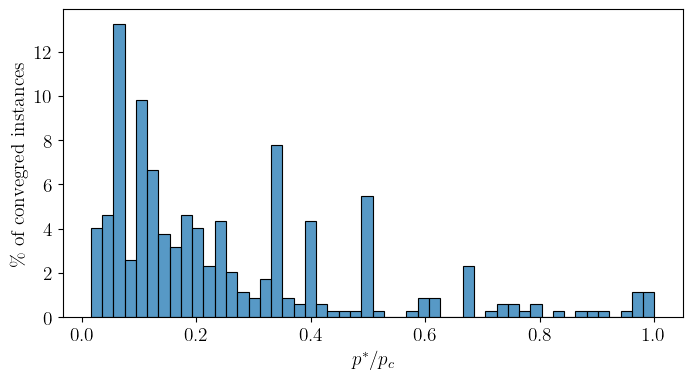

In [43]:
plt.figure(figsize=(8, 4))
ar = np.concatenate(p_star_list/p_c_list)
ar = ar[~np.isnan(ar)]
sns.histplot(ar, kde=False, bins=50, stat="percent")
plt.xlabel(r"$p^*/p_c$")
plt.ylabel(r"\% of convegred instances")
plt.show()

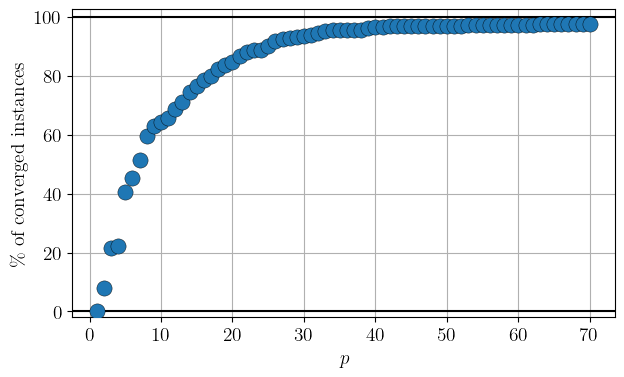

In [45]:
counts_list_sum = np.sum(np.sum(array(counts_list) > 0, axis=1), axis=0)
denom = len(m_list)*(s_max - s_min + 1)/100

sta = 0
fin = 70
markers = ["o", "s", "^"]
plt.figure(figsize=(7, 4))
err_th_lg = int(np.log10(error_threshold))
plt.scatter(arange(p_min, p_max + 1)[sta:fin], counts_list_sum[sta:fin]/denom, 
            ec="black", linewidth=0.3, s=120, label=r"$\epsilon=10^{%d}$" %(err_th_lg), zorder=7)
plt.axhline(0, color="black")
plt.axhline(100, color="black")
plt.xlabel(r"$p$")
plt.ylabel(r"\% of converged instances")
plt.ylim(-2)
# plt.legend(framealpha=1)
plt.grid(zorder=-1)
# plt.savefig(file_name + ".png", transparent=True, bbox_inches='tight')
plt.show()

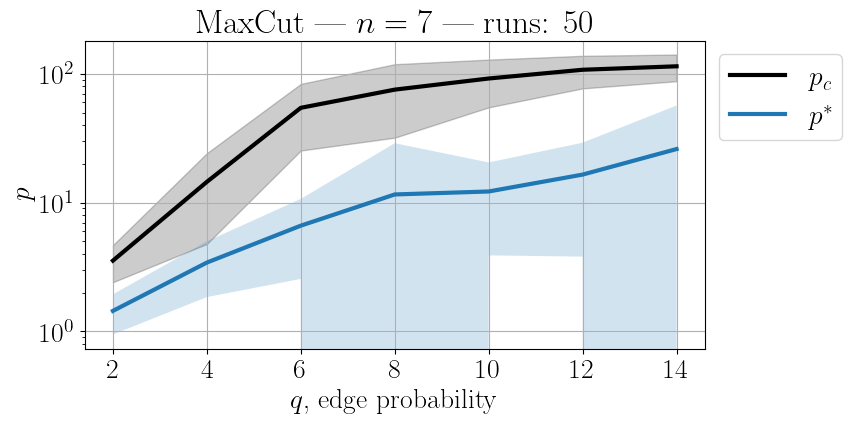

In [50]:
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize=(8, 4))
plt.plot(m_list, np.mean(p_c_list, axis=1), label=r"$p_c$", linewidth=3, color="black")
plt.fill_between(m_list, np.mean(p_c_list, axis=1) - np.std(p_c_list, axis=1), np.mean(p_c_list, axis=1) + np.std(p_c_list, axis=1), alpha=0.2, color="black") 
err_th_lg = int(np.log10(error_threshold))
p_stars_mean_i = np.nanmean(p_star_list, axis=1)
p_stars_std_i = np.nanstd(p_star_list, axis=1)
plt.plot(m_list, p_stars_mean_i, label=r"$p^*$", linewidth=3) 
plt.fill_between(m_list, p_stars_mean_i - p_stars_std_i, p_stars_mean_i + p_stars_std_i, alpha=0.2) 
plt.xlabel(r"$q$, edge probability")
plt.ylabel(r"$p$")
plt.title(r"MaxCut | $n=%d$ | runs: %d" %(n, r_max - r_min + 1))
plt.yscale("log")
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(zorder=-1)
plt.show()